In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from kt_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

%matplotlib inline

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_original_images():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    images = np.array(train_dataset["train_set_x"][:])
    labels = np.array(train_dataset["train_set_y"][:])
    return images, labels
    
images, labels = get_original_images()

In [4]:
def show_n_images(n, images, labels):
    a = np.sqrt(n)
    if not float.is_integer(a):
        a += 1
    a = int(a)
    
    fig, axs = plt.subplots(nrows=a, ncols=a, figsize=(10, 10))
    random_indexes = np.random.randint(0, images.shape[0], size=n)
    fig.tight_layout()
    for ax_idx, img_idx in enumerate(random_indexes):
        label = 'Happy' if labels[img_idx] == 1 else 'Unhappy'
        ax = axs.flat[ax_idx]
        ax.imshow(images[img_idx])
        ax.set_axis_off()
        ax.set_title(label)
        
    for i in range(n, a*a):
        ax = axs.flat[i]
        ax.remove()
        

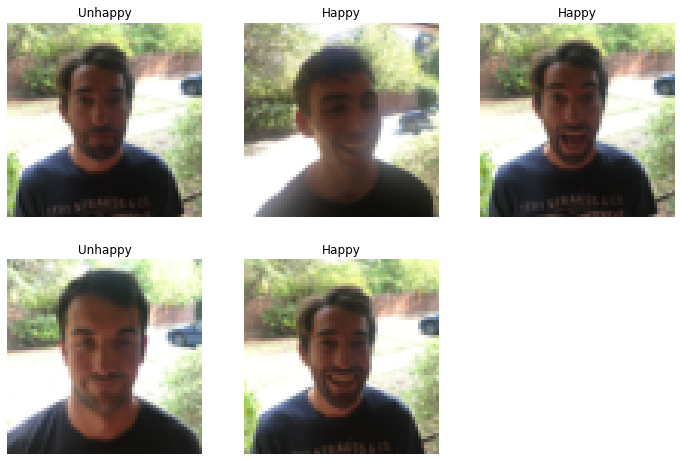

In [5]:
show_n_images(5, images, labels)

In [6]:
X_train_np, Y_train_np, X_test_np, Y_test_np, classes = load_dataset()

print ("number of training examples = " + str(X_train_np.shape[0]))
print ("number of test examples = " + str(X_test_np.shape[0]))
print ("X_train shape: " + str(X_train_np.shape))
print ("Y_train shape: " + str(Y_train_np.shape))
print ("X_test shape: " + str(X_test_np.shape))
print ("Y_test shape: " + str(Y_test_np.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 3, 64, 64)
Y_train shape: (600, 1)
X_test shape: (150, 3, 64, 64)
Y_test shape: (150, 1)


In [7]:
def get_loaders(X_train_numpy, Y_train_numpy, X_test_numpy, Y_test_numpy):
    X_train_tensor = torch.tensor(X_train_numpy, dtype=torch.float)
    Y_train_tensor = torch.tensor(Y_train_numpy, dtype=torch.float)
    
    X_test_tensor = torch.tensor(X_test_numpy, dtype=torch.float)
    Y_test_tensor = torch.tensor(Y_test_numpy, dtype=torch.float)
    
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    
    return train_loader, test_loader
    

In [8]:
X_train_numpy, Y_train_numpy, X_test_numpy, Y_test_numpy, classes = load_dataset()
train_loader, test_loader = get_loaders(X_train_numpy, Y_train_numpy, X_test_numpy, Y_test_numpy)

In [9]:
model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(32768, 1)
).to(device)

In [10]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def get_accuracy(model, loader):
    model.eval()
    total_items = 0
    total_correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            total_items += x.size(0)
            y_pred = torch.sigmoid(model(x))
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            total_correct += (y_pred == y).sum().item()
    return total_correct / total_items

In [12]:
def train(model, train_loader, test_loader, epochs=1):
    model.train()
    iteration = 1
    for epoch in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            optimizer.zero_grad()
            loss = loss_fn(y_pred.view(-1), y.view(-1))
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('loss.data:', loss.item())
            iteration += 1
            
        test_acc = get_accuracy(model, test_loader)
        train_acc = get_accuracy(model, train_loader)
        print(f'epoch: {epoch} | train accuracy: {train_acc} | test accuracy: {test_acc}')

In [13]:
train(model, train_loader, test_loader, epochs=10)

epoch: 0 | train accuracy: 0.58 | test accuracy: 0.5466666666666666
epoch: 1 | train accuracy: 0.58 | test accuracy: 0.5733333333333334
epoch: 2 | train accuracy: 0.55 | test accuracy: 0.6066666666666667
epoch: 3 | train accuracy: 0.855 | test accuracy: 0.76
epoch: 4 | train accuracy: 0.855 | test accuracy: 0.7666666666666667
epoch: 5 | train accuracy: 0.77 | test accuracy: 0.7666666666666667
epoch: 6 | train accuracy: 0.9133333333333333 | test accuracy: 0.88
epoch: 7 | train accuracy: 0.905 | test accuracy: 0.8466666666666667
epoch: 8 | train accuracy: 0.945 | test accuracy: 0.9333333333333333
loss.data: 0.25137993693351746
epoch: 9 | train accuracy: 0.9433333333333334 | test accuracy: 0.9133333333333333


In [14]:
def predict(model, image_tensor):
    model.eval()
    y_pred = torch.sigmoid(model(image_tensor))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    return y_pred

Prediction: Happy


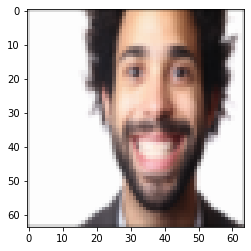

In [15]:
from skimage.transform import resize
fname = "images/smile1.jpg"
image = np.array(plt.imread(fname))
my_image = resize(image, (64,64), mode='constant')
plt.imshow(my_image)

image_tensor = torch.tensor(my_image.transpose(2, 0, 1), dtype=torch.float).to(device)

y_pred = predict(model, image_tensor.view(1, 3, 64, 64))

if y_pred.item() == 1:
    print('Prediction: Happy')
else:
    print('Prediction: Unhappy')
    